# Chapter 03 - Classification

Voy a trabajar con el dataset MNIST

In [14]:
from sklearn.datasets import fetch_openml
import pandas as pd
import numpy as np

In [2]:
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


Ok. 70000 observaciones. Cada observación tiene 784 pixeles (28 x 28)

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

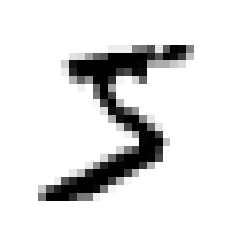

In [10]:
# Tomo una observación de ejemplo
test_digit = X.values[0]
test_label = y[0]

test_digit_image = test_digit.reshape(28, 28)

plt.imshow(test_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [11]:
test_label

'5'

Plotteo el 5, y veo que el label es un 5

In [17]:
# Como veo que el label es una string. Convierto toda la serie y a int
y = y.astype(np.uint8)
y.dtype

dtype('uint8')

Check

In [20]:
# Separo en train y test sets 
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
# Esto es válido porque el dataset ya viene shuffled. Si no, tendría que separarlo y shufflearlo. No podría hacer el split directamente así.

## Binary classifier
### 5 vs not-5

In [22]:
# Tomo, de los datasets de training y testing, solo los registros cuyo target sea 5
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [23]:
y_test_5

60000    False
60001    False
60002    False
60003    False
60004    False
         ...  
69995    False
69996    False
69997    False
69998     True
69999    False
Name: class, Length: 10000, dtype: bool

#### Esto me va a decir True si es 5 y false si no es 5

In [25]:
# "SGDClassifier es un buen lugar para empezar. Funciona bien con large datasets. It deals with training instances independently"
from sklearn.linear_model import SGDClassifier

In [26]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

sgd_clf.predict([test_digit])

array([ True])

In [27]:
test_label

'5'

Bien! Predice 5 y el true label es efectivamente 5

### Classifier performance meassures
Esto es lo más importante. Saber evaluar un classifier es CLAVE

In [28]:
# Primero, voy al cross_val score, como hice con la regresión
from sklearn.model_selection import cross_val_score

In [29]:
# Evalúo, mediante cross validation, la performance del clasificador
scores = cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")
for score in scores:
    print(score * 100, "%")

95.035 %
96.035 %
96.04 %


### Trampa de accuracy! 95% Parece MUY bueno. Pero en los clasificadores, la accuracy sola no nos dice mucho. Especialmente cuando los datasets no son parejos en cuanto a distribución de clases. En este caso, la clase 5 representa un 10% del dataset, y la clase not-5 representa un 90% del dataset

In [31]:
# Ejemplo para mostrar la trampa de accuracy:
# Armo un predictor que SIEMPRE devuelva not-5. (independientemente del input)
from sklearn.base import BaseEstimator

class Never_5(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [34]:
nvr_5 = Never_5()

nvr_5.fit(X_train, y_train_5)

not_5_scores = cross_val_score(nvr_5, X_train, y_train_5, cv = 3, scoring="accuracy")
for score in not_5_scores:
    print(score * 100, "%")

91.125 %
90.85499999999999 %
90.915 %


De paso... así es como se define un custom estimator
### Con este estimator que predice SIEMPRE la majority class, tenemos un accuracy de 91%. Ahora, 95% no parece taaan bueno

### Confusion matrix
Vamos a ver qué errores está cometiendo el algoritmo

In [35]:
from sklearn.model_selection import cross_val_predict

In [40]:
# Cross val predict es como cross_val_score. Pero te devuelve las predicciones en lugar de devolverte los scores
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
# AHH. El cv=3 decide en cuántos folds separa. Esto va a devolver una predicción para cada elemento en el training set. MUY UTIL!
y_train_pred

array([ True, False, False, ...,  True, False, False])

In [42]:
len(y_train_pred)

60000

In [45]:
# Ahora si, vamos a la confusion matrix
from sklearn.metrics import confusion_matrix

confusion_matrix(y_pred=y_train_pred, y_true=y_train_5)

array([[53892,   687],
       [ 1891,  3530]])

Eje vertical: Actual classes, Eje horizontal: Predicted classes<br>
Rows: actual classes, Columns: predicted classes <br>
El orden de las filas / columnas es Negative, Positive. Es decir, el primer cuadrante es Negative / Negative

#### A partir de la confusion matrix puedo calcular precision y recall, métricas que complementan el accuracy. Me muestran algo más parecido a la imagen completa

In [50]:
from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_true=y_train_5, y_pred=y_train_pred)
recall = recall_score(y_true=y_train_5, y_pred=y_train_pred)

print(f"precision: {round(precision, 4) * 100} %")
print(f"recall: {round(recall, 4) * 100} %")

precision: 83.71 %
recall: 65.12 %


Precision = Minimiza FP (falsos positivos)<br>
Recall = Minimiza FN (falsos negativos)

In [52]:
# f1 score es la media harmónica entre precision y recall
from sklearn.metrics import f1_score

f1_score = f1_score(y_true=y_train_5, y_pred=y_train_pred)
f1_score

0.7325171197343846

Como combina precision y recall, el F1 score es bastante utilizado como métrica. El tema es que tiende a favorecer modelos con precision y recall similares. Personalmente no me gusta demasiado esto. Creo que uno siempre está optimizando para un lado o para otro.

### Jugando con thresholds de decisión para inclinar modificar el trade-off entre precisión y recall
sklearn no te deja tocar directamente los thresholds. Pero nos da el valor de la función de decisión. A partir de este valor, se pueden tomar decisiones con un if (sobre todo en caso de un clasificador binario)

In [53]:
test_y_score = sgd_clf.decision_function([test_digit])
test_y_score

array([2164.22030239])

#### Si yo setteara el threshold en 2000, lo predice como True. Si lo setteo en 3000, lo predice como false. (si subo el threshold, aumento precision a expensas del recall. Voy a tener menos falsos positivos, pero más falsos negativos)

#### ¿Cómo decido el threshold? Vamos a la precision - recall curve 

In [56]:
# Primero, tomo todos los valores de la decision function del training set
y_df_scores = cross_val_predict(estimator=sgd_clf, X=X_train, y=y_train_5, cv=3, method="decision_function")

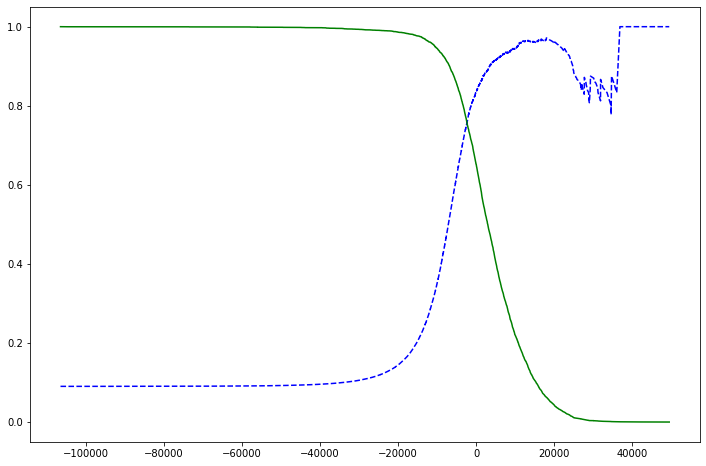

In [61]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_df_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")

plt.figure(figsize=(12, 8))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

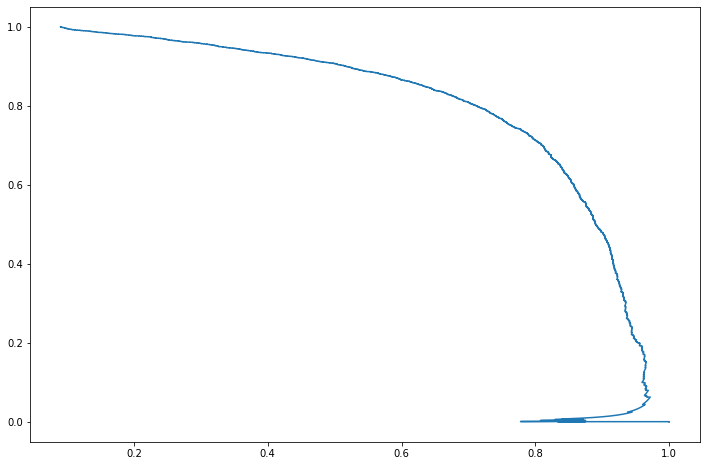

In [62]:
# Plotteo directamente precison vs recall
plt.figure(figsize=(12, 8))
plt.plot(precisions, recalls)
plt.show()

#### A partir de esto, intentemos crear un clasificador con 90% precision.

In [63]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.019499143958

OK. 3370 es el threshold para que el clasificador tenga 90% de precision.

In [64]:
# Tomo los y_df_scores que calculé antes.
y_train_pred_90 = (y_df_scores >= threshold_90_precision)
precision_score_90 = precision_score(y_true=y_train_5, y_pred=y_train_pred_90)
recall_score_90 = recall_score(y_true=y_train_5, y_pred=y_train_pred_90)

print(f"precision: {precision_score_90 * 100} %")
print(f"recall: {recall_score_90 * 100} %")

precision: 90.00345901072293 %
recall: 47.99852425751706 %


#### Perfecto. Tengo mi clasificador con 90% de precisión. Pero a expensas de la recall

### ROC Curve. Muy útil

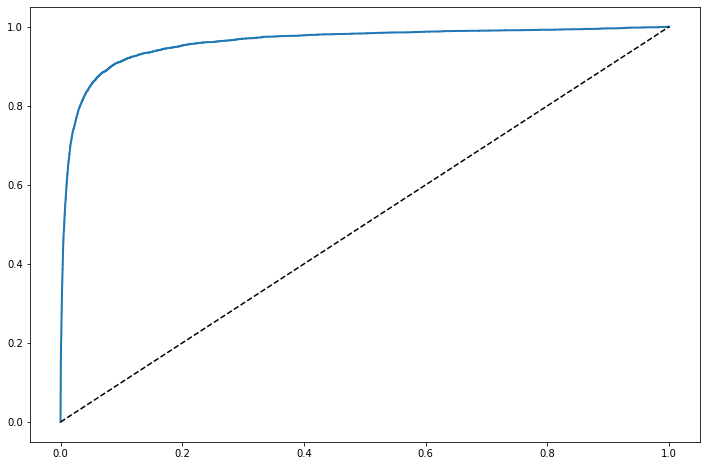

In [65]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_df_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal

plt.figure(figsize=(12, 8))
plot_roc_curve(fpr, tpr)
plt.show()

In [66]:
# El área debajo de la curva ROC permite comparar 2 clasificadores (1 sería un clasificador prefecto. 0.5 sería un clasificador random)
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(y_true=y_train_5, y_score=y_df_scores)
print(roc_auc)

0.9604938554008616


#### Pruebo otro clasificador: RF

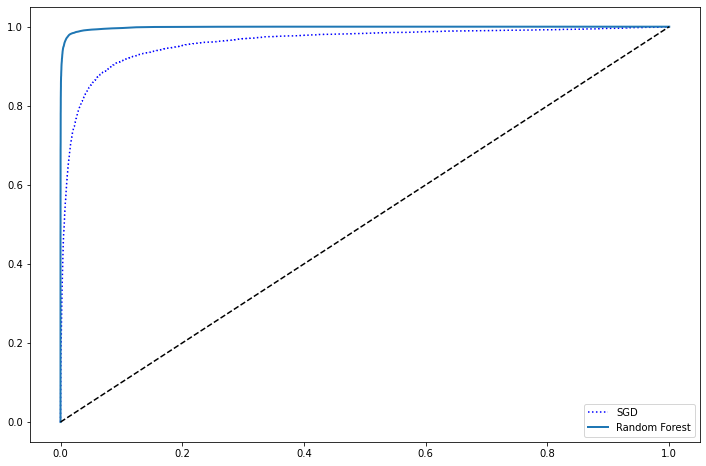

In [67]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,method="predict_proba")

y_scores_forest = y_probas_forest[:, 1]
# score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

plt.figure(figsize=(12, 8))
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [68]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

## Multiclass Classification